In [2]:
#warinng 무시
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import warnings
data=pd.read_csv("arima_data.csv", names=['day', 'price'])
data.head()

,day,price
0,2013-01-01,3794
1,2013-02-01,3863
2,2013-03-01,5190
3,2013-04-01,5783
4,2013-05-01,6298


In [4]:
data['day']=pd.to_datetime(data['day'], format='%Y-%m-%d')
data.set_index('day', inplace=True)
data.head(3)

,price
day,
2013-01-01,3794
2013-02-01,3863
2013-03-01,5190


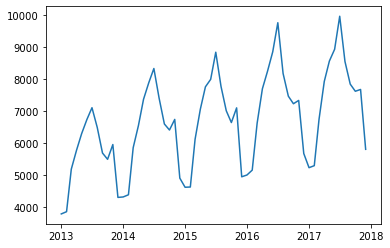

In [5]:
import matplotlib.pyplot as plt
plt.plot(data.index, data['price'])

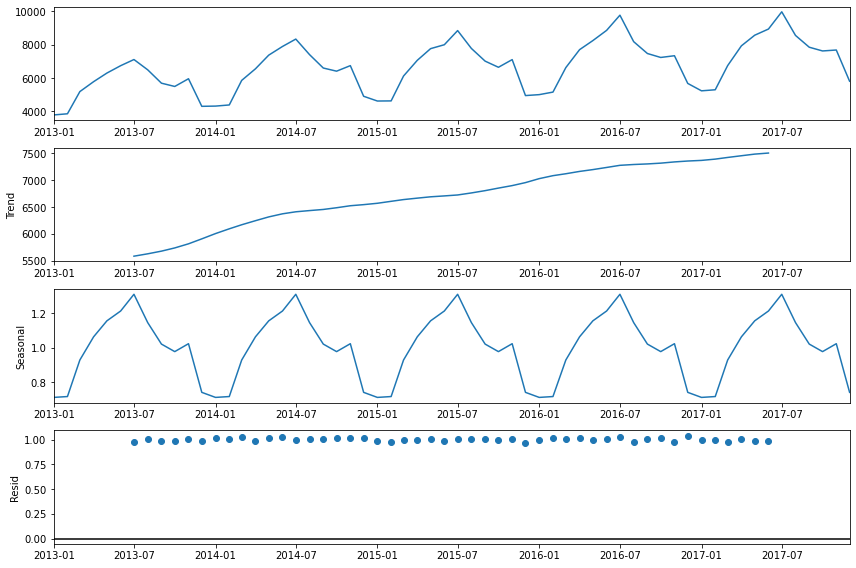

In [6]:
#시계열 분해
from statsmodels.tsa.seasonal import seasonal_decompose
ts=data
result=seasonal_decompose(ts, model='multiplicative')
plt.rcParams['figure.figsize']=[12,8]
result.plot()
plt.show()

### 정상성 검정

In [7]:
data.head()

,price
day,
2013-01-01,3794
2013-02-01,3863
2013-03-01,5190
2013-04-01,5783
2013-05-01,6298


In [8]:
data.tail()

,price
day,
2017-08-01,8548
2017-09-01,7843
2017-10-01,7620
2017-11-01,7676
2017-12-01,5809


-> 2013~2017년 월별 데이터

In [9]:
from statsmodels.tsa.stattools import adfuller

#train 데이터 정의
training=data[:"2016-12-01"]
#test 데이터 정의
test=data.drop(training.index)

#train데이터 정상성 확인
adf=adfuller(training, regression='ct')
print('ADF Statistic: {}'.format(adf[0]))
print('p-value : {}'.format(adf[1]))

ADF Statistic: -1.9997199341327634
p-value : 0.6015863303794268


p-value가 0.05보다 크므로 귀무가설을 기각할 수 없다. 즉 해당 데이터는 비정상성

### 차분 (비정상->정상 시계열)

<AxesSubplot:xlabel='day'>

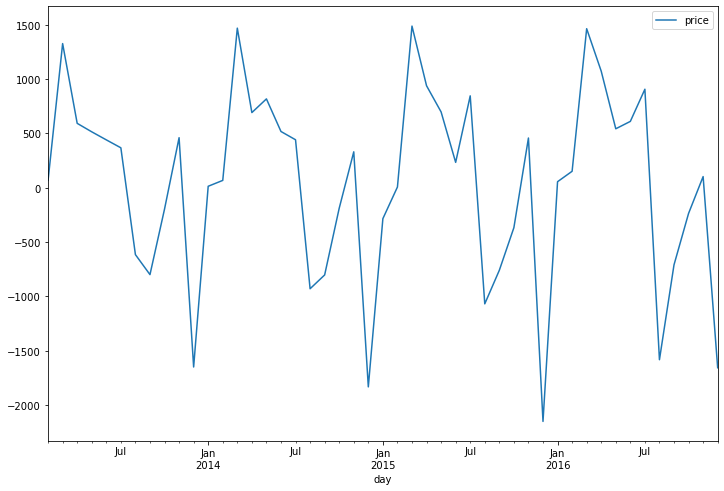

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#train데이터 1차 차분
diff_data=training.diff(1)
diff_data=diff_data.dropna()
diff_data.plot()

In [11]:
adf=adfuller(diff_data, regression='c')
print('ADF Statistic: {}'.format(adf[0]))
print('p-value : {}'.format(adf[1]))

ADF Statistic: -12.094547576926423
p-value : 2.0851606399610975e-22


p-value가 0.05보다 작아 귀무가설을 기각한다.

1차 차분한 그래프를 확인했을 때, 트렌드를 보이지 않기 때문에 매개변수는 "c"값을 이용하여 검정해야 한다.

### AR 모형의 p값 찾기

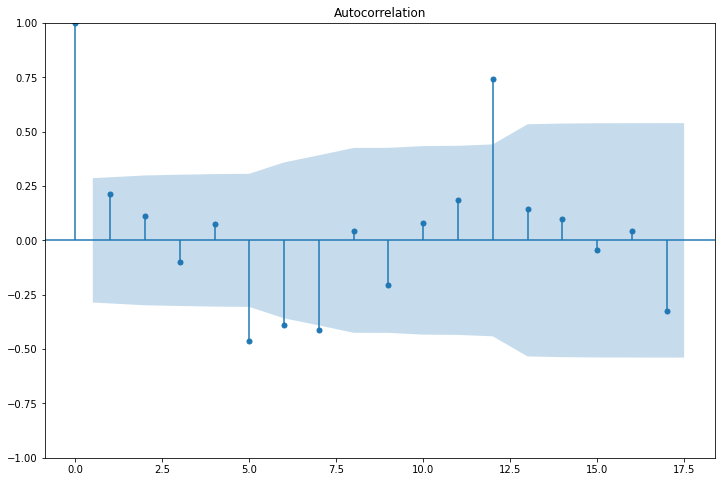

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plot_acf(diff_data)
plt.show()

0으로 수렴할때의 시차값인 2를 p로 설정

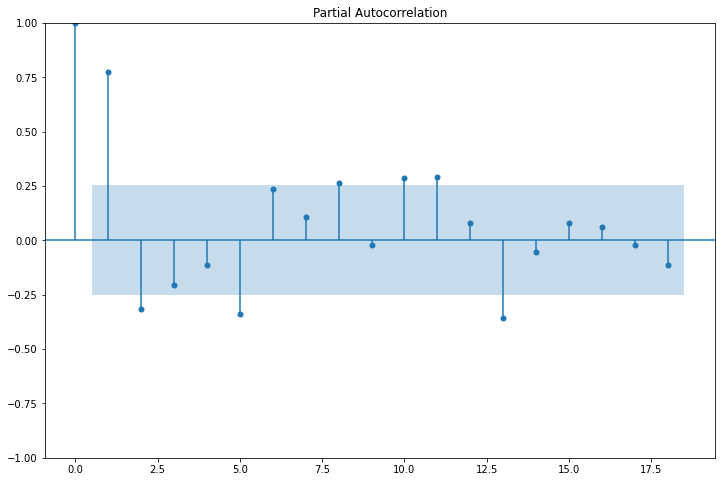

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(data, method='ywm')

plt.show()

MA모형에서 q값은 2로 설정

- p,d,q (2,1,2)값을 ARIMA 적용

In [14]:
from statsmodels.tsa.arima.model import ARIMA

model=ARIMA(training, order=(2,1,2))
res=model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  price   No. Observations:                   48
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -375.875
Date:                Tue, 15 Nov 2022   AIC                            761.750
Time:                        21:56:56   BIC                            771.001
Sample:                    01-01-2013   HQIC                           765.231
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3168      0.190     -6.942      0.000      -1.689      -0.945
ar.L2         -0.3191      0.190     -1.676      0.094      -0.692       0.054
ma.L1          1.9700      0.242      8.125      0.000       1.495       2.445
ma.L2          0.9950      0.241      4.128      0.000       0.523       1.467
sigma2      4.452e+05   1.13e-06   3.93e+11      0.000    4.45e+05    4.45e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 0.38
Prob(Q):                              0.74   Prob(JB):                         0.83
Heteroskedasticity (H):               1.49   Skew:                            -0.21
Prob(H) (two-sided):                  0.44   Kurtosis:                         2.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.83e+26. Standard errors may be unstable.
"""

AR, MA 모형을 사용할 수 있다.

- training데이터의 원래값, 예측값 plot

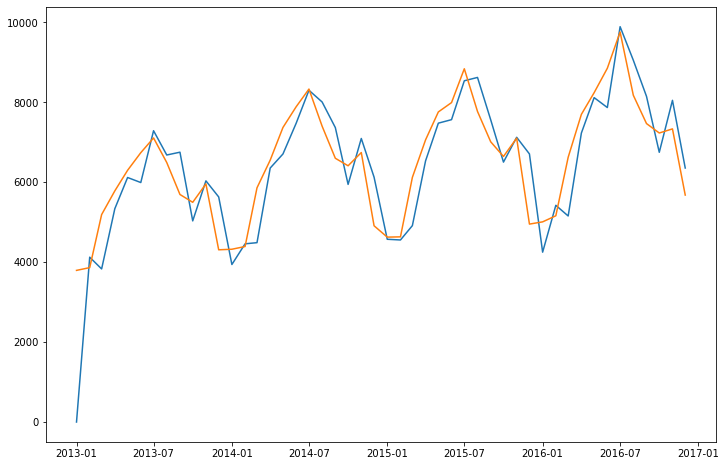

In [15]:
plt.plot(res.predict()) #예측값(train)
plt.plot(training)

그래프 모양이 거의 일치하므로 과소적합은 의심되지 않음

- 2017년 데이터 예측

In [16]:
forecast_data=res.forecast(steps=len(test), alpha=0.05)

pred_y=forecast_data
pred_y #예측값

test_y=test
test_y #실제 test값

,price
day,
2017-01-01,5236
2017-02-01,5299
2017-03-01,6744
2017-04-01,7927
2017-05-01,8561
2017-06-01,8930
2017-07-01,9960
2017-08-01,8548
2017-09-01,7843


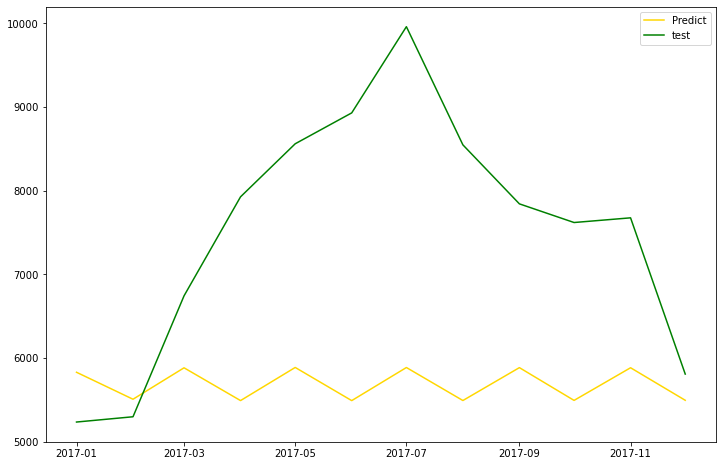

In [17]:
plt.plot(pred_y, color="gold", label='Predict')
plt.plot(test_y, color="green", label='test')
plt.legend()
plt.show()

In [18]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print(r2_score(test_y, pred_y))
print(mean_squared_error(test_y, pred_y)**0.5)

-1.64291725782009
2302.207554223674


R^2값이 음수가 나온다는 것은 해당 모델의 정확도가 매우 낮다는 것이다. 예제에서 사용한 데이터와 같이 계절성이 있는 경우, 계절성 지수가 추가된 SARIMA 모델을 사용하는 것이 좋다.